<h3>OSIC Pulmonary Fibrosis Progression<h3>

https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as tK
import tensorflow.keras.layers as tL
import tensorflow.keras.models as tM

![jupyter](./metric.png)

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def kloss(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 1]
    fvc_pred = y_pred[:, 0]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def kmae(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

Use <font color=Red>Keras: Model  class </font> to build a model that can access features in the Full connection stage

https://keras.io/api/models/model/

In [ ]:
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * kloss(y_true, y_pred) + (1 - _lambda)*kmae(y_true, y_pred)
    return loss
#=================
def make_model():
    ct = tL.Input((125,125,1),name="Ctinput")  
    Patint = tL.Input((9,) name="Patient" ) 
    x =tL.Conv2D(50,(5,5),activation="relu",name="conv1")(ct)
    x =tL.MaxPooling2D(pool_size=(3,3), name='pool1')(x)
    
    x = tL.Conv2D(50,(5,5),activation="relu",name="conv2")(x)
    x = tL.MaxPooling2D(pool_size=(3,3), name='pool2')(x)
    
   
    x = tL.Conv2D(50,(3,3),activation="relu",name="conv3")(x)
    x = tL.MaxPooling2D(pool_size=(2,2), name='pool3')(x)
    
    x = tL.Flatten(name="features")(x)
    x = tL.Dense(50, activation="relu", name="d1")(x)
    P = tL.Dense(10, activation="relu", name="d2")(Patint)
    x = tL.Concatenate(name="combine")([x, P])
    x = tL.Dense(50, activation="relu", name="d3")(x)
    preds = tL.Dense(2, activation="softmax", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    #model.compile(loss=kmae, optimizer="adam", metrics=[kloss])
    #model.compile(loss=kloss, optimizer="adam", metrics=[kmae])#
    return model

In [8]:
df_train= pd.read_csv("train.csv")
df_test= pd.read_csv("test.csv")

In [12]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


100%|██████████| 71/71 [00:01<00:00, 36.90it/s]


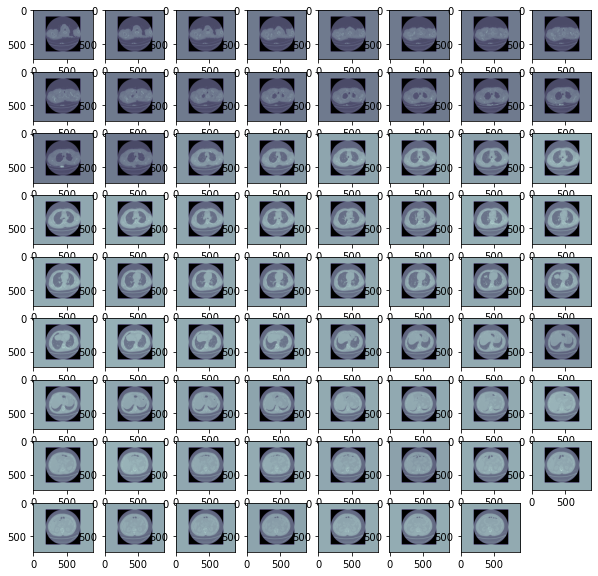

In [15]:
Patient_list= df_train["Patient"].unique()
def getDcms(patient):
    image_dir = 'train/'+patient
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)
    columns = int(np.sqrt(len(image_list)))
    rows = columns+1
    dcms=[]
    for i in tqdm(range(1, len(image_list) +1)):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    return dcms

list=getDcms(Patient_list[50])

In [6]:
df_test["Sex"]=df_test["Sex"].astype("category").cat.codes
df_test["SmokingStatus"]=df_test["SmokingStatus"].astype("category").cat.codes

df_train["Sex"]=df_train["Sex"].astype("category").cat.codes
df_train["SmokingStatus"]=df_train["SmokingStatus"].astype("category").cat.codes


df_test["Weeks"]=(df_test["Weeks"]-df_test["Weeks"].mean())/df_test["Weeks"].std()


In [44]:
def get_Weeks_Dcms():
    fig=plt.figure(figsize=(10,10))
    dcms=[]
    plist=[]
    wlist=[]
    for p in tqdm(Patient_list):
        image_dir = 'train/'+p
        image_list = os.listdir(image_dir)
        week=df_train[df_train["Patient"]==p]["Weeks"]
        for w in week:
            try:
                ds = pydicom.dcmread(image_dir + "/" + str(w) + ".dcm")
                dcms.append(ds.pixel_array)
                plist.append(p)
                wlist.append(w)
            except:
                pass
    data = pd.DataFrame({"Patient":plist,"Weeks":wlist})        
    return dcms,data

In [45]:
x_train,data_train=get_Weeks_Dcms()

100%|██████████| 176/176 [00:03<00:00, 49.63it/s]


<Figure size 720x720 with 0 Axes>